Расмотрим пример на датасете из репозитория UCI

Описание данных - https://archive.ics.uci.edu/ml/datasets/banknote+authentication#

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score
from matplotlib import pyplot as plt

In [2]:
def evaluate_results(y_test_val, y_predict_val, print_status = False):
    f1 = f1_score(y_test_val, y_predict_val)
    roc = roc_auc_score(y_test_val, y_predict_val)
    rec = recall_score(y_test_val, y_predict_val, average='binary') 
    prc = precision_score(y_test_val, y_predict_val, average='binary')
    if print_status:
        print('Classification results:')
        print("f1: %.2f%%" % (f1 * 100.0)) 
        print("roc: %.2f%%" % (roc * 100.0))
        print("recall: %.2f%%" % (rec * 100.0))
        print("precision: %.2f%%" % (prc * 100.0))
    else:
        return f1, roc, rec, prc

## Урок 6. Задача look-alike
### Домашнее задание
1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [3]:
data = pd.read_csv("data_banknote_authentication.txt", header=None)
data.head(3)

,0,1,2,3,4
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


In [4]:
print(data.shape)

(1372, 5)


Cоотношение классов

In [5]:
data.iloc[:, -1].value_counts()

0    762
1    610
Name: 4, dtype: int64

Разбиваем выборку на тренировочную и тестовую части и обучаем модель

In [6]:
x_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=7)

In [7]:
# Initialize LGBMClassifier
model = LGBMClassifier(learning_rate=0.085,max_depth=3,random_state=12) # max_depth<=0 means no limit
# Fit model
model.fit(x_train, y_train)
# Get predicted classes
y_predict = model.predict(x_test)

Проверяем качество

In [8]:
evaluate_results(y_test, y_predict, True)
initial_classif_res = evaluate_results(y_test, y_predict)

Classification results:
f1: 99.13%
roc: 99.21%
recall: 98.84%
precision: 99.42%


### Теперь очередь за PU learning

Представим, что нам неизвестны негативы и часть позитивов

In [9]:
mod_data = data.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 153/610 as positives and unlabeling the rest


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [10]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    1219
 1     153
Name: class_test, dtype: int64


In [12]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

### 1. random negative sampling

In [13]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(153, 6) (153, 6)


In [14]:
model = LGBMClassifier(learning_rate=0.09,max_depth=5,random_state=12) # max_depth<=0 means no limit

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict, True)

Classification results:
f1: 98.74%
roc: 99.26%
recall: 100.00%
precision: 97.52%


In [15]:
mod_data = data.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)


# try a number of values of the positives marked
pos_sample_len = int(np.ceil(0.05 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

# Initialize LGBMClassifier
model = LGBMClassifier(learning_rate=0.09,max_depth=5,random_state=12) # max_depth<=0 means no limit
# Fit model
model.fit(sample_train.iloc[:,:-2].values, sample_train.iloc[:,-2].values)
# Get predicted classes
y_predict = model.predict(sample_test.iloc[:,:-2].values)

evaluate_results(sample_test.iloc[:,-2].values, y_predict, True)

Using 31/610 as positives and unlabeling the rest
target variable:
 -1    1341
 1      31
Name: class_test, dtype: int64
(31, 6) (31, 6)
Classification results:
f1: 91.09%
roc: 92.65%
recall: 100.00%
precision: 83.63%


In [17]:
classif_data = np.array(([]))
for part in np.arange(0.1,1,.033):
    mod_data = data.copy()
    #get the indices of the positives samples
    pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
    #shuffle them
    np.random.shuffle(pos_ind)

    # try a number of values of the positives marked
    pos_sample_len = int(np.ceil(part * len(pos_ind)))
    pos_sample = pos_ind[:pos_sample_len]

    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1

    x_data = mod_data.iloc[:,:-2].values # just the X 
    y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
    y_positive = mod_data.iloc[:,-2].values # original class

    mod_data = mod_data.sample(frac=1)
    neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
    sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
    pos_sample = mod_data[mod_data['class_test']==1]
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

    # Initialize LGBMClassifier
    model = LGBMClassifier(learning_rate=0.085,max_depth=3,random_state=12) # max_depth<=0 means no limit
    # Fit model
    model.fit(sample_train.iloc[:,:-2].values, sample_train.iloc[:,-2].values)
    # Get predicted classes
    y_predict = model.predict(sample_test.iloc[:,:-2].values)

    # Get predicted probabilities for each class
    #preds_proba = model.predict_proba(eval_data)
    # Get predicted RawFormulaVal
    #preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')
    f1, roc, rec, prc = evaluate_results(sample_test.iloc[:,-2].values, y_predict)
    classif_data = np.append(classif_data, [part, f1, roc, rec, prc])



In [18]:
classif_data = np.reshape(classif_data,(-1,5))

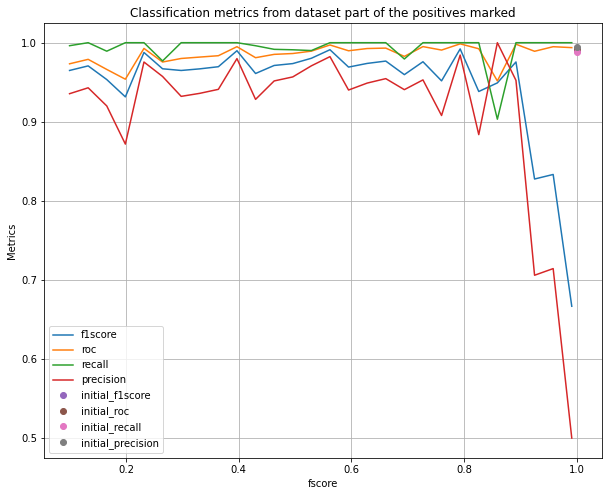

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(classif_data[:,0], classif_data[:,1], label='f1score')
plt.plot(classif_data[:,0], classif_data[:,2], label='roc')
plt.plot(classif_data[:,0], classif_data[:,3], label='recall')
plt.plot(classif_data[:,0], classif_data[:,4], label='precision')
plt.plot(1, initial_classif_res[0],'o', label='initial_f1score')
plt.plot(1, initial_classif_res[1],'o', label='initial_roc')
plt.plot(1, initial_classif_res[2],'o', label='initial_recall')
plt.plot(1, initial_classif_res[3],'o', label='initial_precision')

plt.title('Classification metrics from dataset part of the positives marked')
plt.ylabel('Metrics')
plt.xlabel('fscore')
plt.legend()
plt.grid(True)
